# COGS 189 Analysis

In [1]:
import numpy as np   
import matplotlib.pyplot as plt    
import pandas as pd
import mne

In [2]:
# %matplotlib widget

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

// This disables scrolling outputs

<IPython.core.display.Javascript object>

# Read data with added stim channel
See find_peaks_stim_channel.ipynb for generating the stim channel from aux data.

In [4]:
data = pd.read_csv("exp0_sub0_8ch_1stim.csv") # Amy
#data = pd.read_csv("exp0_sub1_8ch_1stim.csv") # Andres
data.head()

Unnamed: 0          EXG0          EXG1         EXG2          EXG3  \
0           0  12584.725032  15524.024132 -2317.138292  17950.261289   
1           1  12595.587980  15529.410902 -2316.959478  17958.352620   
2           2  12579.830000  15523.957077 -2315.327801  17950.641269   
3           3      0.000000      0.000000     0.000000      0.000000   
4           4  12535.305325  15492.910503 -2324.290851  17940.381818   

           EXG4         EXG5          EXG6          EXG7  Analog0  Analog1  \
0  14667.952319  7234.834997  18205.361748  19735.338656    421.0    621.0   
1  14691.756927  7232.622174  18216.045882  19740.792482    402.0    516.0   
2  14672.221502  7231.638698  18202.008987  19733.751682    387.0    445.0   
3      0.000000     0.000000      0.000000      0.000000    445.0    768.0   
4  14577.673623  7226.006058  18228.495804  19714.976217    423.0    622.0   

   Analog2     Timestamp  stim  
0    511.0  1.677707e+09     0  
1    511.0  1.677707e+09     0  
2    511.0  1.677707e+09     0  
3    511.0  1.677707e+09     0  
4    511.0  1.677707e+09     0

# Rescale data from uV to V

In [5]:
eeg_chans = [ch for ch in data if 'EXG' in ch]
data[eeg_chans] /= 1e6 # only run this once!
data[eeg_chans]

EXG0      EXG1      EXG2      EXG3      EXG4      EXG5      EXG6  \
0       0.012585  0.015524 -0.002317  0.017950  0.014668  0.007235  0.018205   
1       0.012596  0.015529 -0.002317  0.017958  0.014692  0.007233  0.018216   
2       0.012580  0.015524 -0.002315  0.017951  0.014672  0.007232  0.018202   
3       0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
4       0.012535  0.015493 -0.002324  0.017940  0.014578  0.007226  0.018228   
...          ...       ...       ...       ...       ...       ...       ...   
201703  0.013771  0.014851 -0.004501  0.020286  0.018994  0.006362  0.019783   
201704  0.013107  0.014606 -0.004438  0.019796  0.017392  0.006200  0.018913   
201705  0.013206  0.014599 -0.004461  0.019757  0.017268  0.006227  0.018918   
201706  0.013903  0.014849 -0.004529  0.020233  0.018855  0.006398  0.019812   
201707  0.013870  0.014881 -0.004518  0.020326  0.019157  0.006378  0.019899   

            EXG7  
0       0.019735  
1       0.019741  
2       0.019734  
3       0.000000  
4       0.019715  
...          ...  
201703  0.020563  
201704  0.019904  
201705  0.019924  
201706  0.020596  
201707  0.020647  

[201708 rows x 8 columns]

<AxesSubplot: >

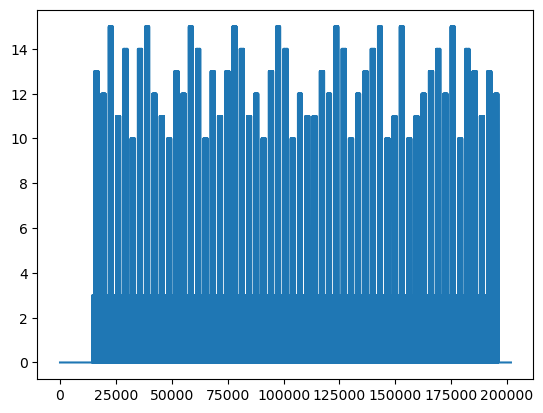

In [6]:
data['stim'].plot()

# Import Channel Map
(this was just written out as a txt file during data collection)

In [7]:
chan_map_path = r'../data/exp0/OpenBCISession_2023-03-01_13-30-42/chan_map.txt'
# for exp0, same channel map was used for both subjects

chan_map = pd.read_csv(chan_map_path,
                      delimiter='\t')
chan_map

Cyton   004
0    REF  CPz
1    GND  AFz
2      1   Fz
3      2   Cz
4      3   Pz
5      4  Fp1
6      5   F7
7      6   T6
8     7    T4
9      8   T3

# Make an MNE Info Object

In [8]:
FS_EEG = 250.0

col_names = data.keys()

nchan = len(eeg_chans)
print('#Channels:', nchan)

# Container to populate with MNE channel types
ch_names = ['']*len(col_names)
ch_types = ['']*len(col_names)

ch_ndx = 0
for col in col_names:
    # print(ch_ndx, col)
    if 'EXG' in col:
        ch_names[ch_ndx] = chan_map.iloc[ch_ndx+1, 1]
        print(ch_ndx, ch_names[ch_ndx])
        ch_types[ch_ndx] = 'eeg'
    elif 'stim' in col:
        ch_names[ch_ndx] = col
        ch_types[ch_ndx] = 'stim'
    else: # Analog / Timestamp
        ch_names[ch_ndx] = col
        ch_types[ch_ndx] = 'misc'
    ch_ndx += 1

info = mne.create_info(
    ch_names=ch_names, 
    sfreq=FS_EEG, 
    ch_types=ch_types
)

# Apply 10-20 montage for these channels
info.set_montage('standard_1020', match_case=False)

#Channels: 8
1 Fz
2 Cz
3 Pz
4 Fp1
5 F7
6 T6
7 T4
8 T3


<Info | 8 non-empty values
 bads: []
 ch_names: Unnamed: 0, Fz, Cz, Pz, Fp1, F7, T6, T4, T3, Analog0, Analog1, ...
 chs: 5 misc, 8 EEG, 1 Stimulus
 custom_ref_applied: False
 dig: 11 items (3 Cardinal, 8 EEG)
 highpass: 0.0 Hz
 lowpass: 125.0 Hz
 meas_date: unspecified
 nchan: 14
 projs: []
 sfreq: 250.0 Hz
>

# Import the data into MNE

In [9]:
# Need to transpose the data
raw = mne.io.RawArray(data.T, info)

raw

Creating RawArray with float64 data, n_channels=14, n_times=201708
    Range : 0 ... 201707 =      0.000 ...   806.828 secs
Ready.


<RawArray | 14 x 201708 (806.8 s), ~21.6 MB, data loaded>

# Try a PSD plot of raw data
Watch out for 60 Hz!

Using matplotlib as 2D backend.


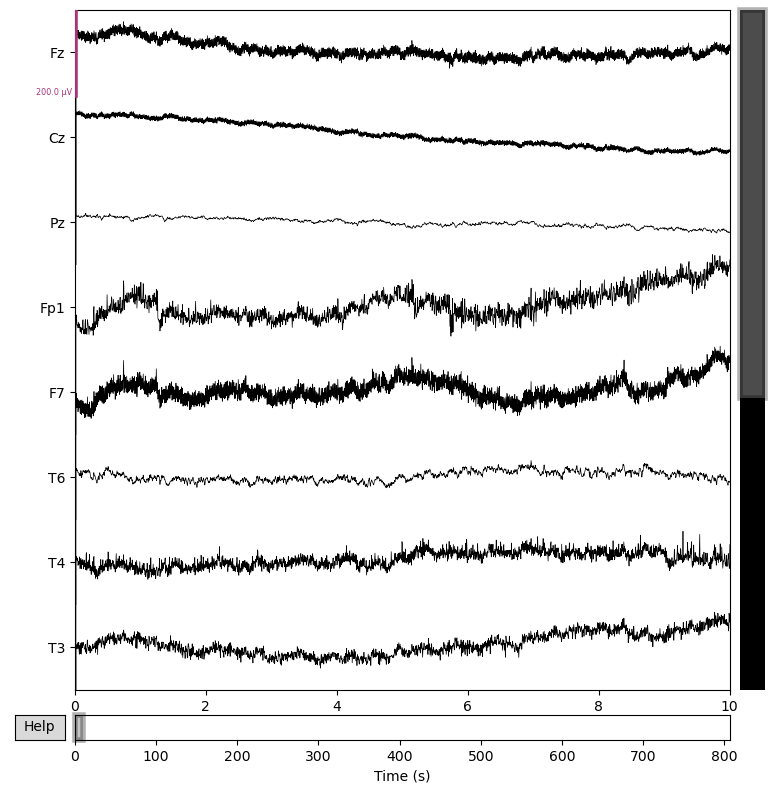

Effective window size : 1.024 (s)


/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


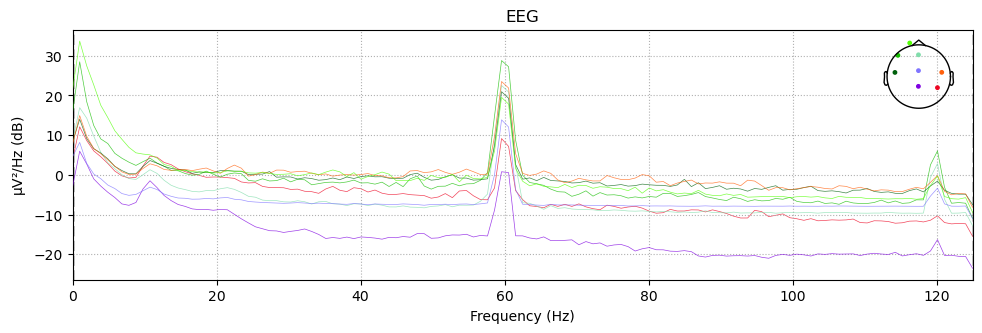

In [10]:
scalings = {'eeg': 100e-6, 'bio': 1, 'time': 1}

raw.plot(n_channels=8, scalings=scalings, title='test',
         show=True, block=True)


raw.compute_psd().plot(average = False)

# Bandpass Filter
https://mne.tools/dev/auto_tutorials/preprocessing/30_filtering_resampling.html

In [11]:
raw_filtered = raw.copy().filter(
    l_freq = 0.1, 
    h_freq = 30
)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 8251 samples (33.004 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.1s finished


Effective window size : 1.024 (s)


/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


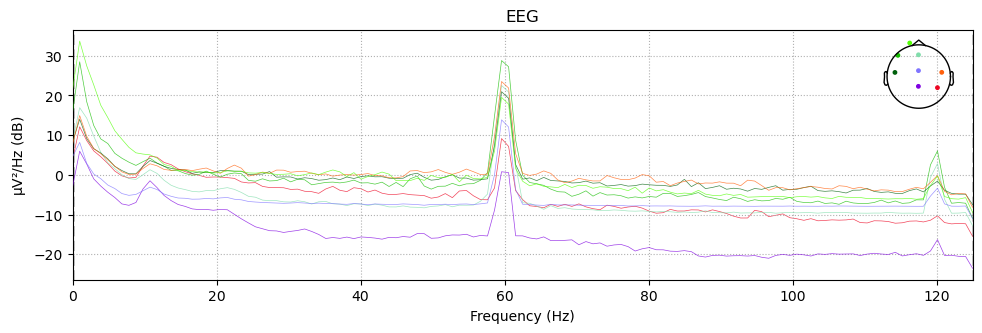

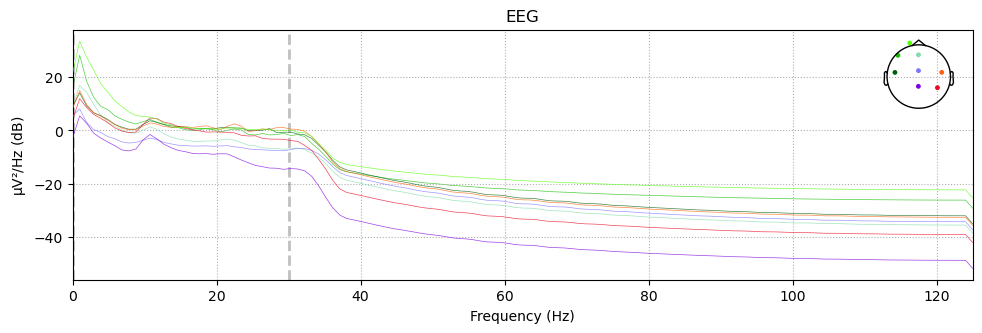

In [12]:
raw_filtered.compute_psd().plot(average = False)
plt.show()

# Set reference to average
https://mne.tools/stable/auto_tutorials/preprocessing/55_setting_eeg_reference.html

In [13]:
raw_filtered.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawArray | 14 x 201708 (806.8 s), ~21.6 MB, data loaded>

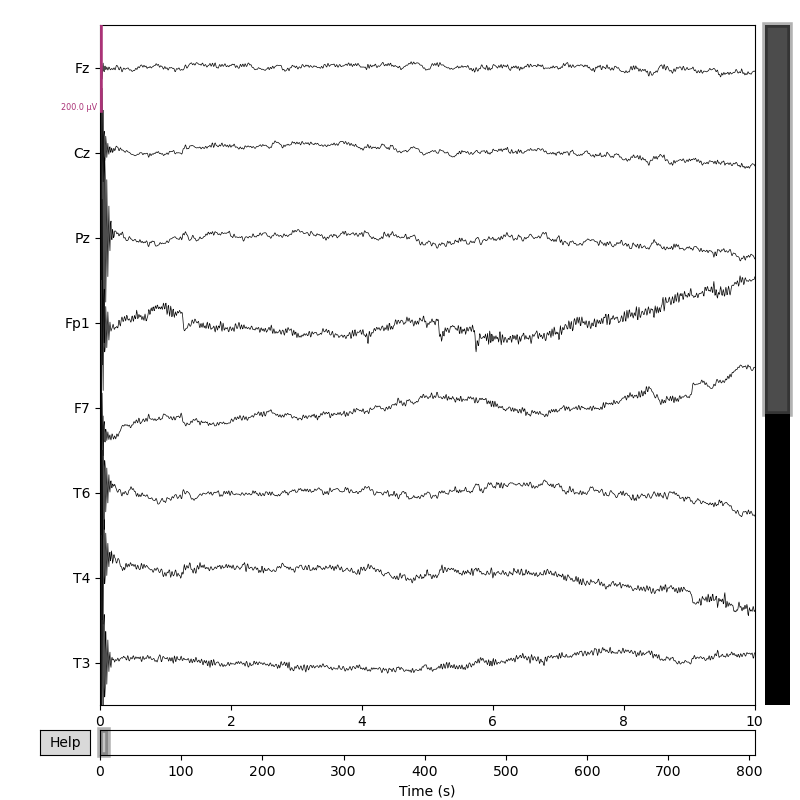

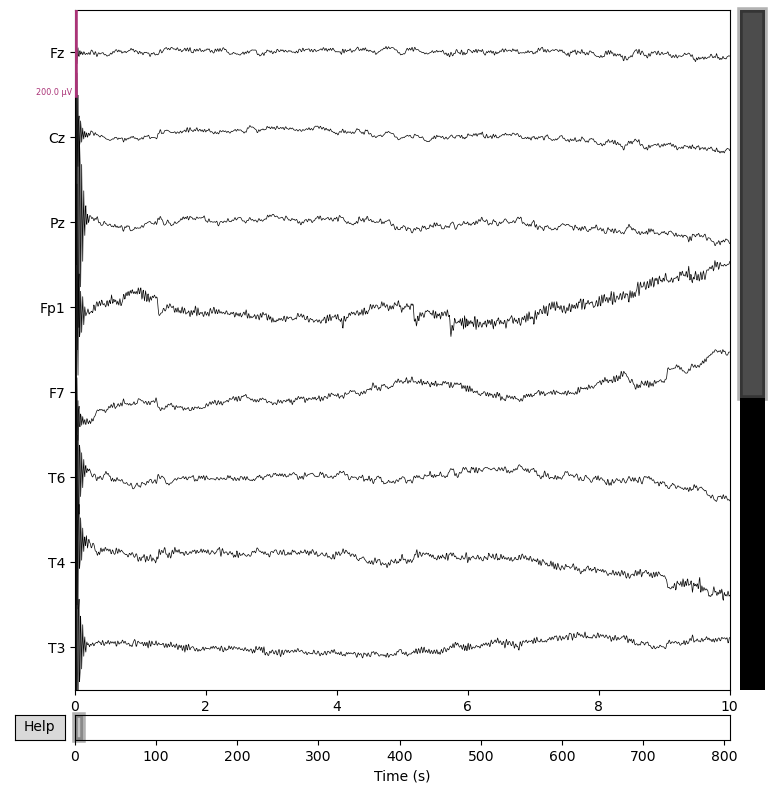

In [14]:
%matplotlib widget

raw_filtered.plot(n_channels=8, scalings=scalings, title='test',
         show=True, block=True)

# Epoch
https://mne.tools/stable/generated/mne.find_events.html

## Trigger Labels

Trigger | Description
:-- | :--
0 | nothing
1 | trial start (loud cue)
2 | loud cue
3 | soft cue
X | auto-assigned by stim wave used

X by stim file used:

```
 'audio/exp0/kick_iso.wav': 10,
 'audio/exp0/kick_mp1.wav': 11,
 'audio/exp0/kick_mp2.wav': 12,
 'audio/exp0/snare_iso.wav': 13,
 'audio/exp0/snare_mp1.wav': 14,
 'audio/exp0/snare_mp2.wav': 15
```

In [15]:
events = mne.find_events(raw)

1344 events found
Event IDs: [ 1  2  3 10 11 12 13 14 15]


In [17]:
event_dict = {
    'cue/start': 1,
    'cue/loud': 2,
    'cue/soft': 3,
    'kick/iso': 10,
    'kick/mp1': 11,
    'kick/mp2': 12,
    'snare/iso': 13,
    'snare/mp1': 14,
    'snare/mp2': 15
}

In [18]:
epochs = mne.Epochs(
    raw_filtered, 
    events, 
    tmin=-0.2, 
    tmax=0.5, 
    event_id=event_dict,
    preload=True
)

Not setting metadata
1344 matching events found
Setting baseline interval to [-0.2, 0.0] sec
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 1344 events and 176 original time points ...
0 bad epochs dropped


# ICA

Fitting ICA to data using 8 channels (please be patient, this may take a while)
Selecting by number: 8 components


/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_7248/800801495.py:8: RuntimeWarning: The epochs you passed to ICA.fit() were baseline-corrected. However, we suggest to fit ICA only on data that has been high-pass filtered, but NOT baseline-corrected.
  ica.fit(epochs)


Fitting ICA took 0.5s.
    Using multitaper spectrum estimation with 7 DPSS windows


/var/folders/st/wjnxghxn7_b382gv3l4lxt0m0000gn/T/ipykernel_7248/800801495.py:8: RuntimeWarning: Using n_components=8 (resulting in n_components_=8) may lead to an unstable mixing matrix estimation because the ratio between the largest (7.2) and smallest (7.1e-32) variances is too large (> 1e6); consider setting n_components=0.999999 or an integer <= 7
  ica.fit(epochs)


Not setting metadata
403 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
403 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
403 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
403 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
403 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
403 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
403 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
403 matching events found
No baseline correction applied
0 projection items activated


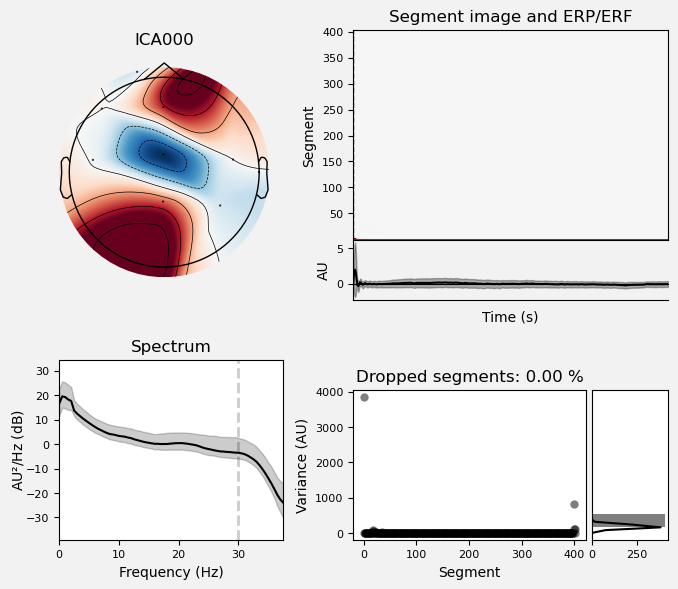

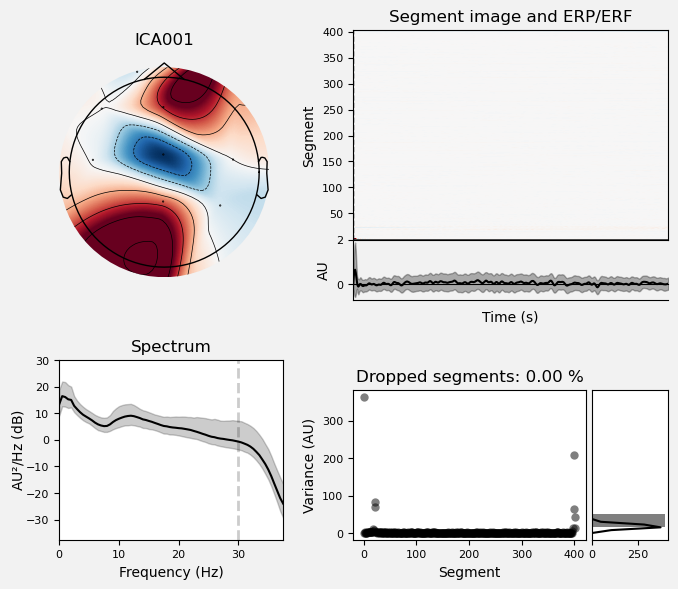

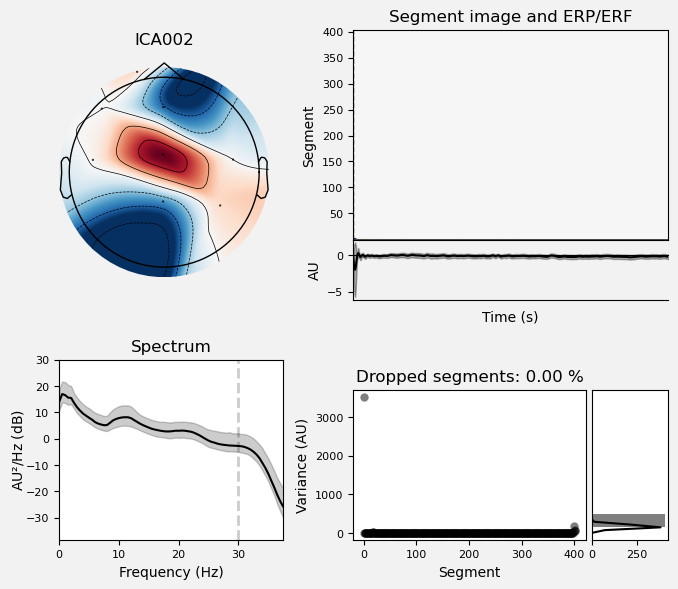

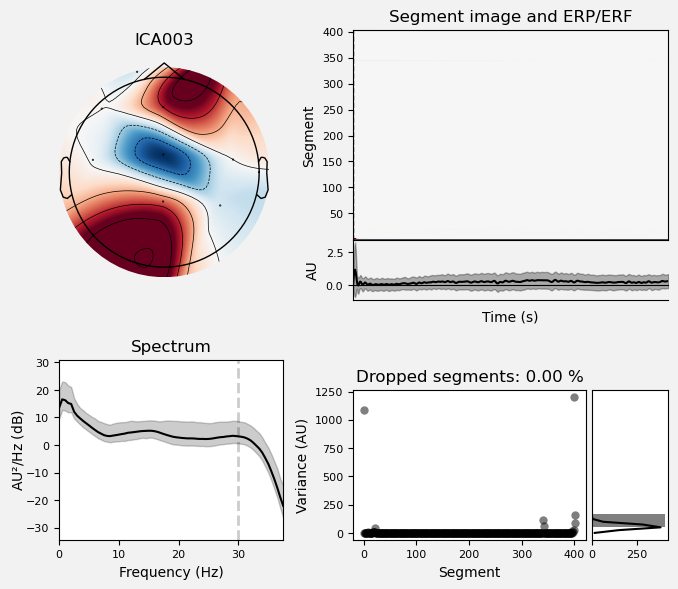

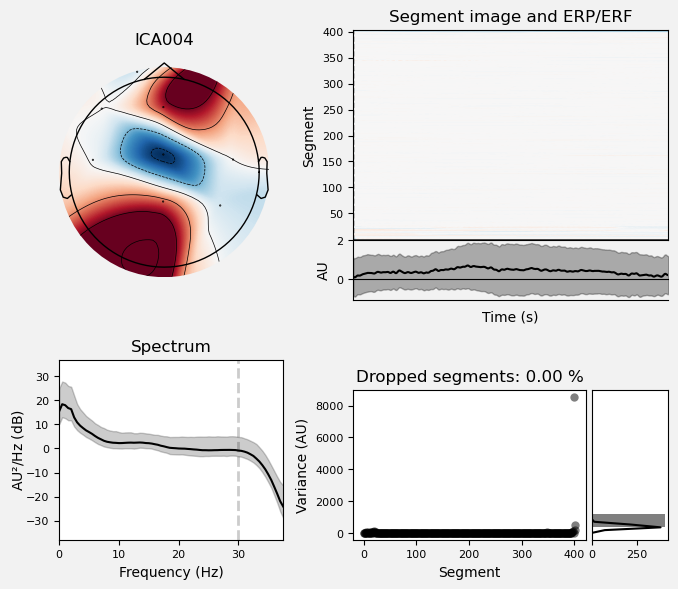

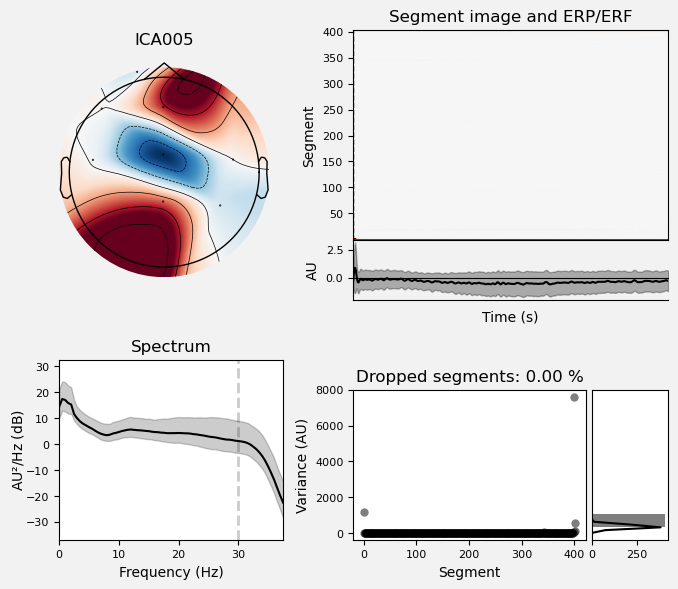

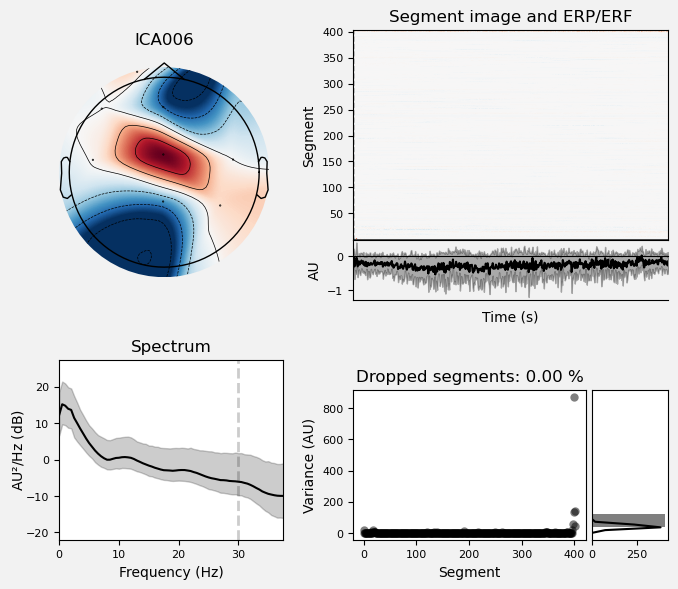

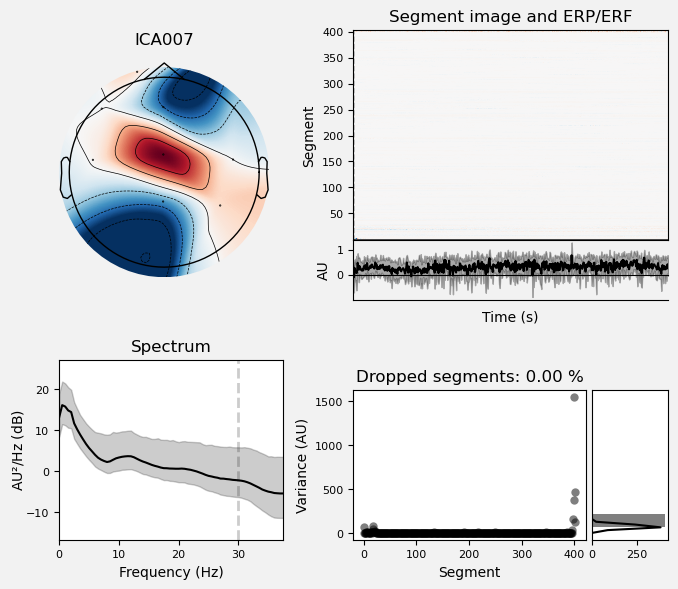

In [19]:
%matplotlib inline

# set up and fit the ICA
ica = mne.preprocessing.ICA(
    n_components=nchan,
)

ica.fit(epochs)

#ica.exclude = [1, 2]  # details on how we picked these are omitted here

ica.plot_properties(raw_filtered, picks=range(nchan))
plt.show()

Applying ICA to Raw instance
    Transforming to ICA space (8 components)
    Zeroing out 1 ICA component
    Projecting back using 8 PCA components


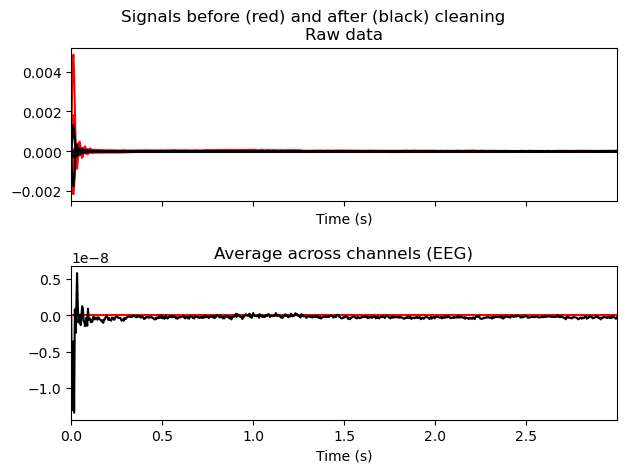

In [21]:
%matplotlib inline 

ica.plot_overlay(raw_filtered, exclude=[1], picks='eeg')
plt.show()

Not setting metadata
1344 matching events found
No baseline correction applied
0 projection items activated


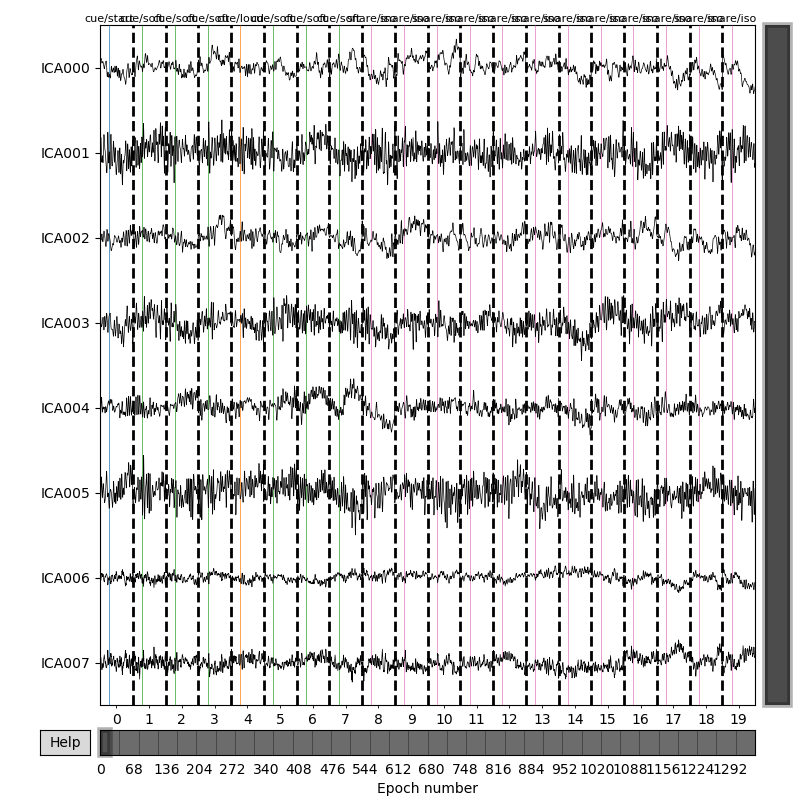

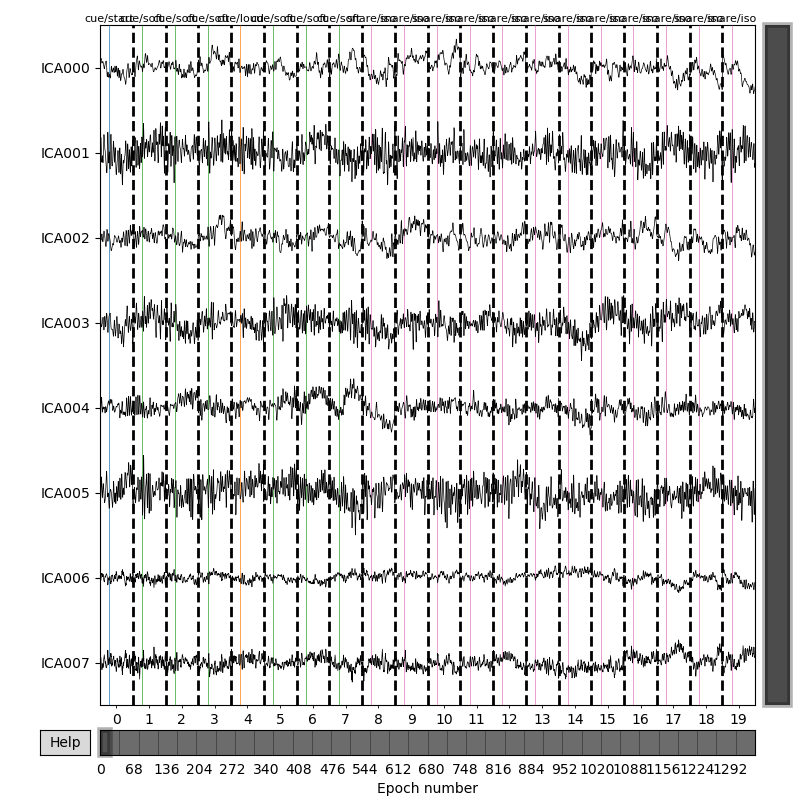

In [22]:
%matplotlib widget

ica.plot_sources(epochs, show_scrollbars=True)
plt.show()

# Spectra

    Using multitaper spectrum estimation with 7 DPSS windows
Averaging across epochs...


/opt/anaconda3/lib/python3.9/site-packages/mne/viz/utils.py:137: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


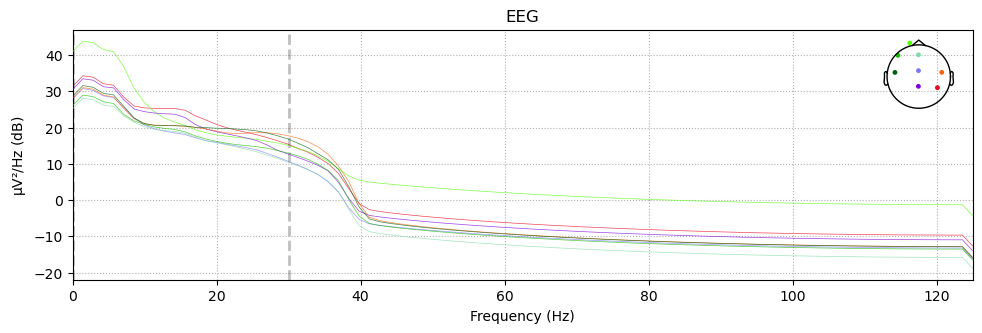

In [23]:
%matplotlib inline 

epochs['kick'].compute_psd().plot(picks='eeg')
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows


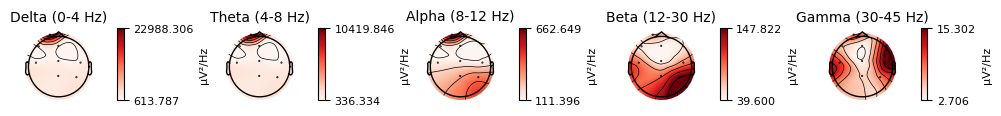

In [24]:
spectrum = epochs['kick'].compute_psd()
spectrum.plot_topomap()
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows


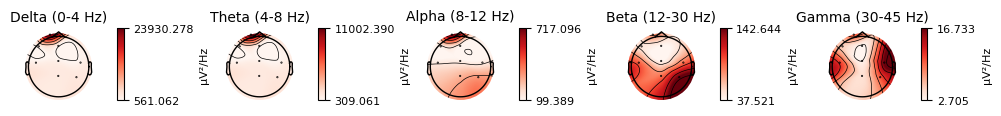

In [25]:
spectrum = epochs['snare'].compute_psd()
spectrum.plot_topomap()
plt.show()

    Using multitaper spectrum estimation with 7 DPSS windows


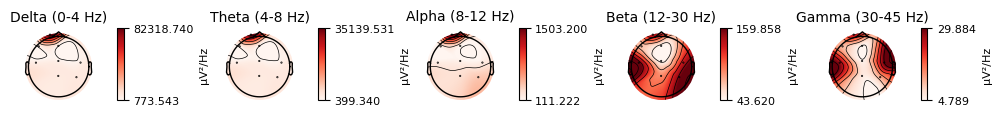

In [26]:
spectrum = epochs['cue'].compute_psd()
spectrum.plot_topomap()
plt.show()

# ERPs

Not setting metadata
144 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


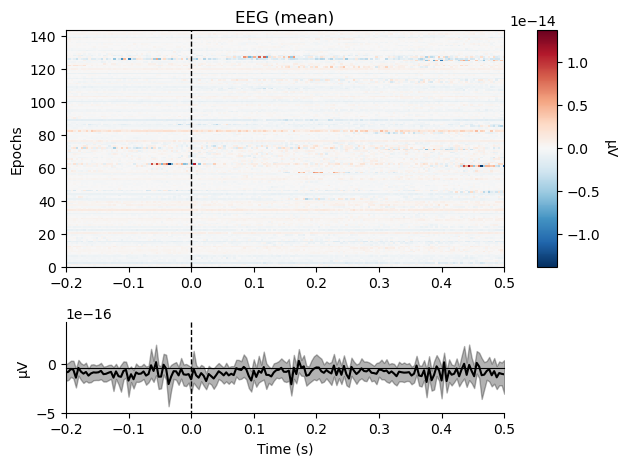

In [27]:
epochs['kick/iso'].plot_image(picks='eeg', combine='mean')
plt.show()

Not setting metadata
160 matching events found
No baseline correction applied
0 projection items activated
combining channels using "mean"


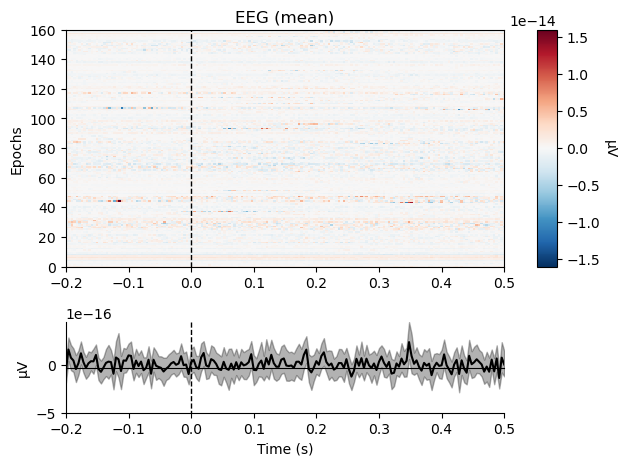

In [28]:
epochs['snare/iso'].plot_image(picks='eeg', combine='mean')
plt.show()

Not setting metadata
448 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


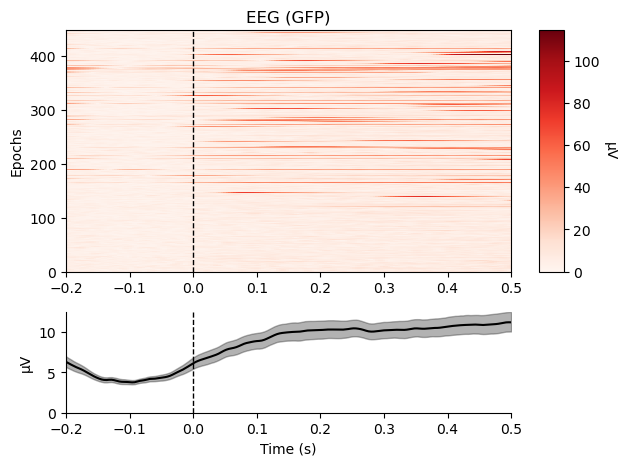

[<Figure size 640x480 with 3 Axes>]

In [29]:
epochs['snare'].plot_image(picks=['eeg'], combine='gfp')


Not setting metadata
448 matching events found
No baseline correction applied
0 projection items activated
combining channels using "gfp"


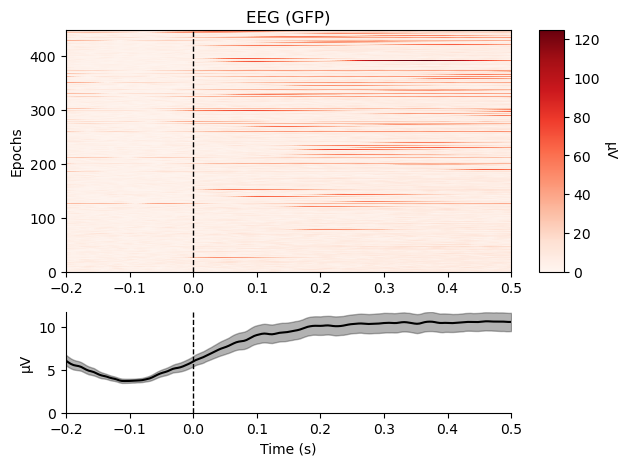

[<Figure size 640x480 with 3 Axes>]

In [30]:
epochs['kick'].plot_image(picks=['eeg'], combine='gfp')
